## A Study about Neighbourhoods of MTR Stations in Hong Kong

### 1. Introducton

Hong Kong is one of the major financial cities in the world, a former British colony and now a Special Administrative Region of the People's Republic of China. It has over 7.5 millions residents and is one of the most densely populated places in the world. 

From report of the Hong Kong government over 90 percent of daily trips are made on public transport. The major public tranpsort network is the Mass Transit Railway (MTR), and it has an average weekday patronage of about 5.6 million passengers. Over the years it has developed into a 11 lines of heavy rail plus 10 lines of light rail commuter network. Most parts of the city are covered by heavy rail while only a small area in the north-west is covered by additional light rail.

As a resident of the city I would like to explore the neighbours around MTR stations in the city, and see how different or alike they are. From which we will try to analyze what local business is popular among the neighbourhoods, and evaluate the business prospects for opening a local business.

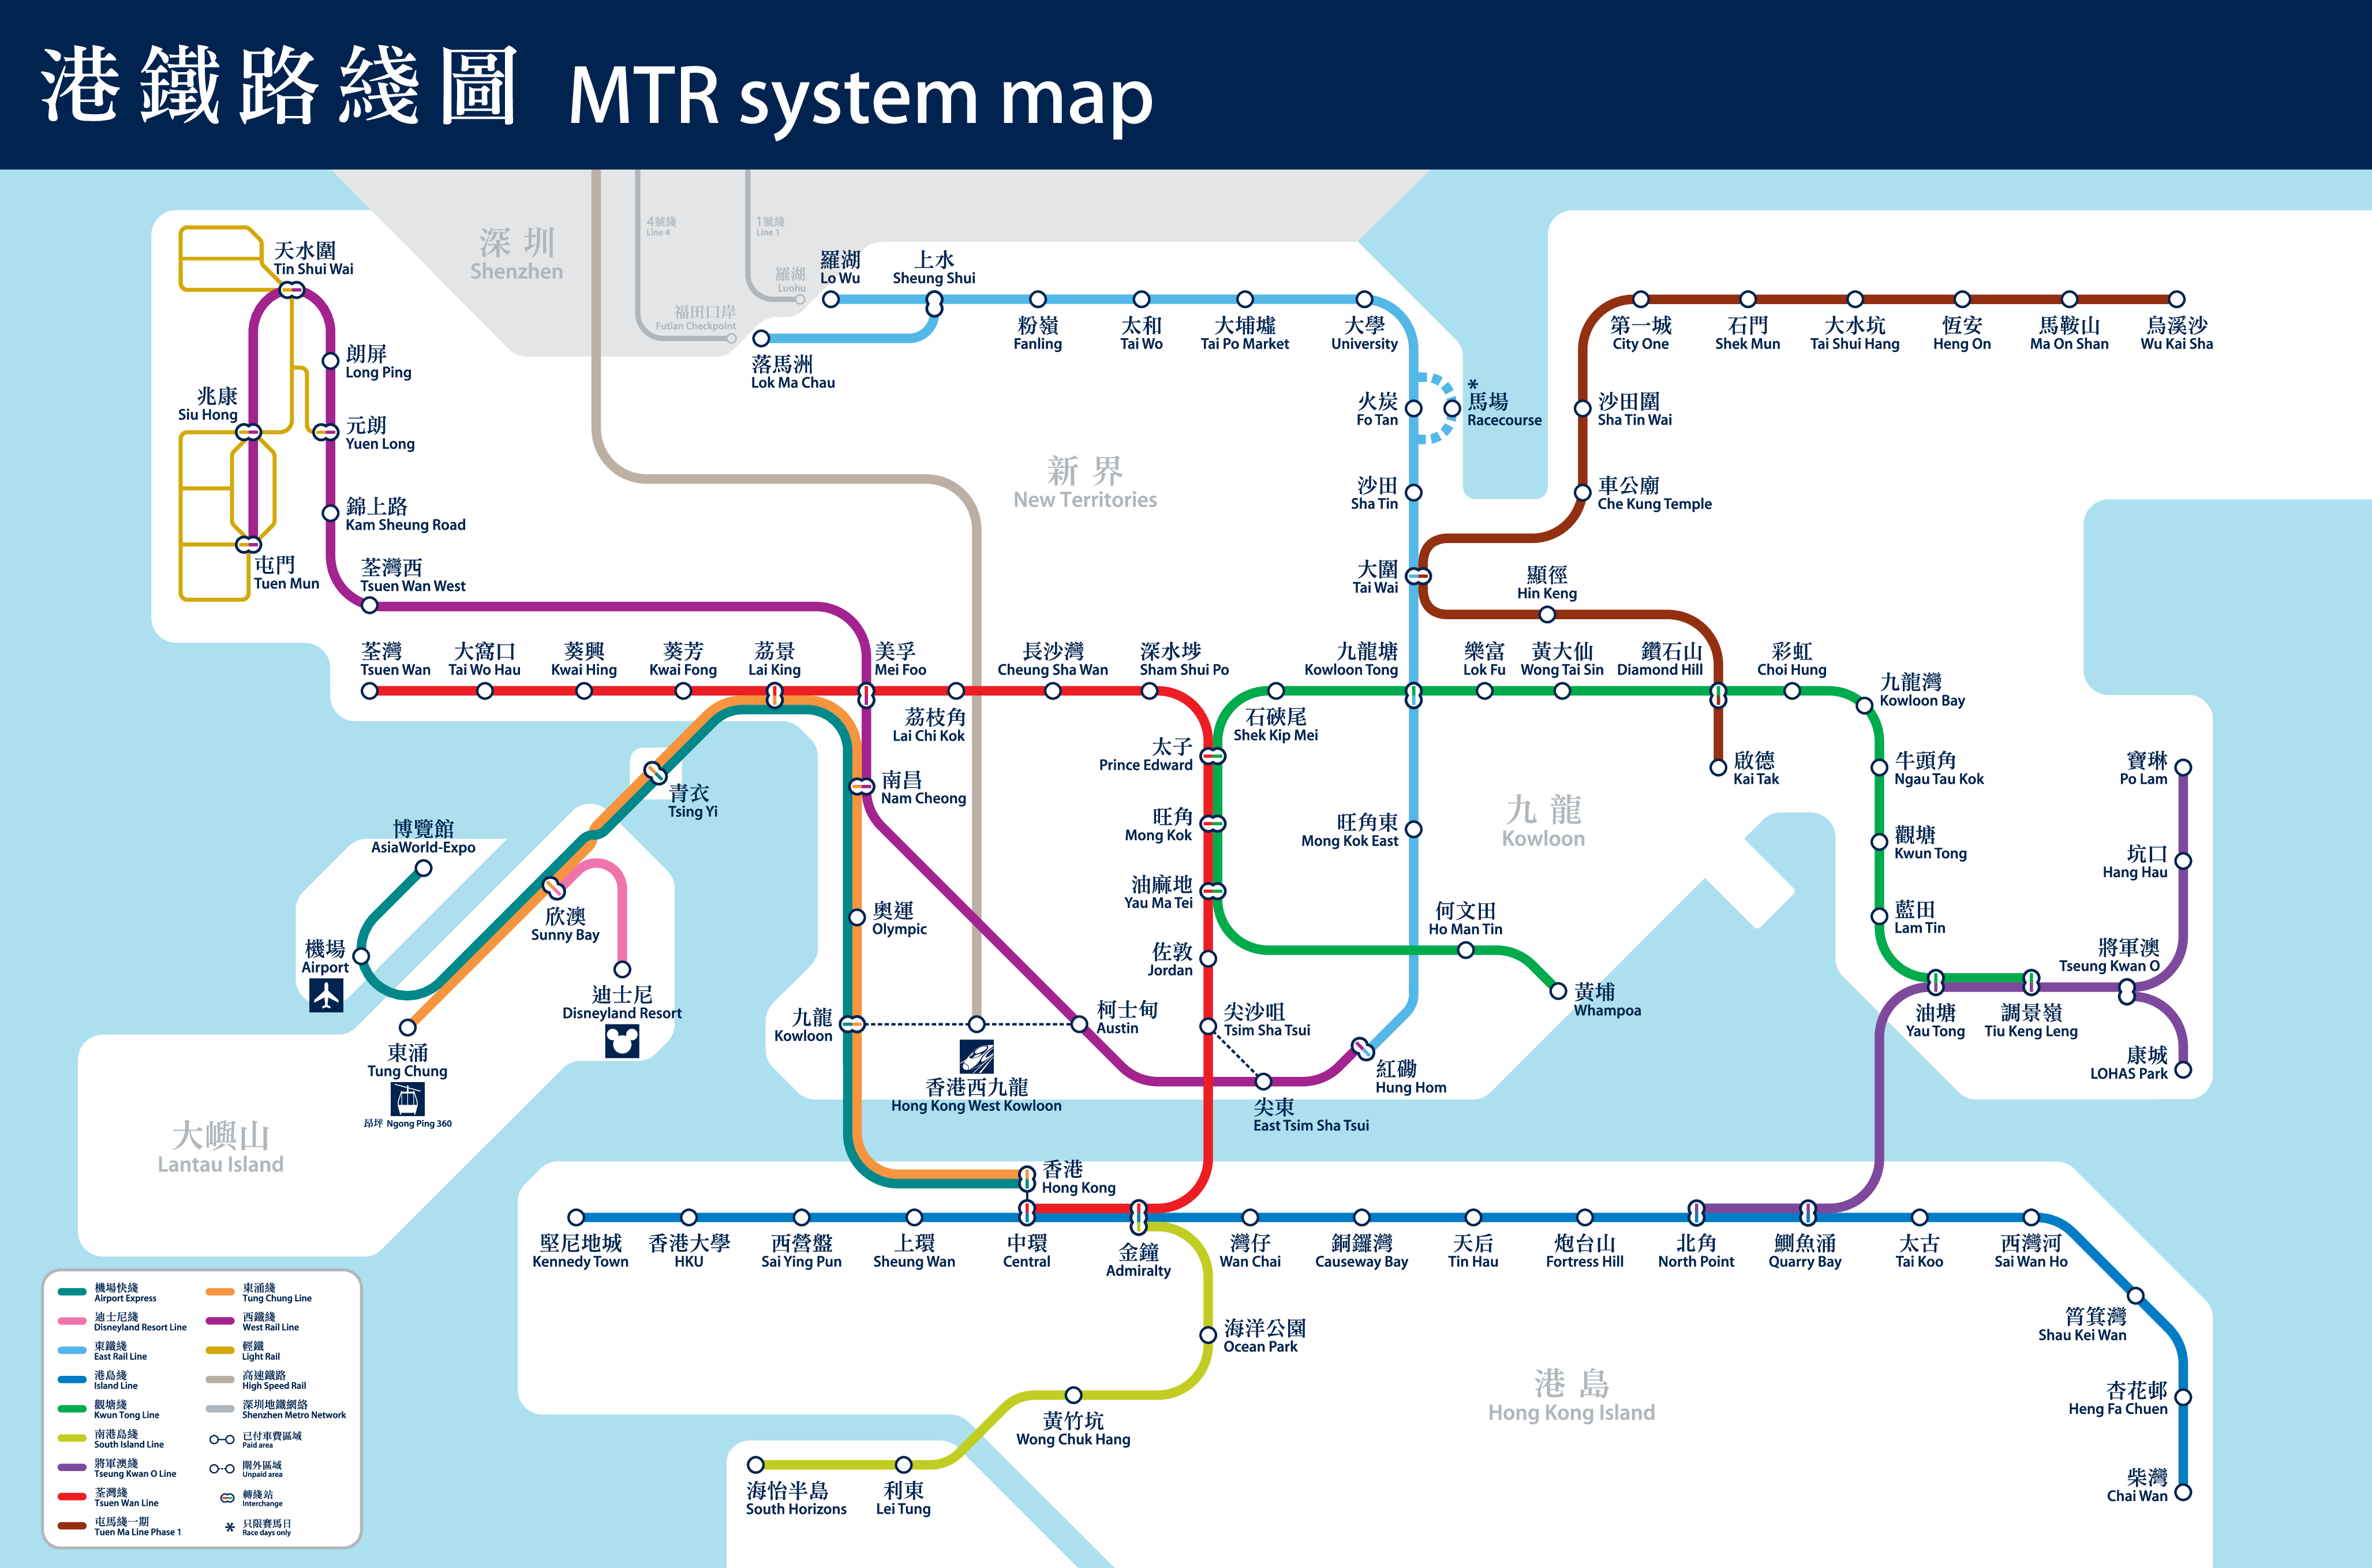

In [1]:
from wand.image import Image as WImage
img = WImage(filename='routemap.pdf')
img

### 2. Data Acquisition

The analysis will use data sources from the Hong Kong government website. From DATA.GOV.HK we can obtain different published data, therefore : 

- we downloaded the MTR routes, fares and barrier-free facilities data set listed on Hong Kong government website. From the csv file we can get the list of all stations in different lines.
- we use geopy to extract latitudes and longitudes for each staion, and validates the location with coordinates from Google Map.
- we use the Foursquare location data to explore the neighbourhood of different stations, providing more details about the neighourhoods.


Here import the necessary library for further processings.

In [2]:
import pandas as pd # import Pandas
import numpy as np # import Numpy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import requests # library to handle requests
import json # library to handle JSON files

import matplotlib.pyplot as plt # import matplotlib for plotting
#import seaborn as sns # import seaborn for plotting
#sns.set(style="darkgrid")
%matplotlib inline

### Preparing Data Set from Sources

We first import the csv downloaded from data.gov.hk website to retrieve the MTR network information.

In [3]:
stations_df = pd.read_csv('mtr_lines_and_stations.csv')
stations_df

,Line Code,Direction,Station Code,Station ID,Chinese Name,English Name,Sequence
0,AEL,DT,AWE,56,博覽館,AsiaWorld-Expo,1.0
1,AEL,DT,AIR,47,機場,Airport,2.0
2,AEL,DT,TSY,46,青衣,Tsing Yi,3.0
3,AEL,DT,KOW,45,九龍,Kowloon,4.0
4,AEL,DT,HOK,44,香港,Hong Kong,5.0
...,...,...,...,...,...,...,...
251,SIL,DT,SOH,89,海怡半島,South Horizons,NaN
252,SIL,DT,LET,88,利東,Lei Tung,2.0
253,SIL,DT,WCH,87,黃竹坑,Wong Chuk Hang,3.0
254,SIL,DT,OCP,86,海洋公園,Ocean Park,4.0


In [4]:
line_names = stations_df['Line Code'].unique()
print('There are {} lines in total.'.format(len(line_names)))
station_names = stations_df['English Name'].unique()
print('There are {} MTR stations in total.'.format(len(station_names)))

There are 11 lines in total.
There are 94 MTR stations in total.


There are in total 94 stations and 11 lines. We will now use geopy to load coordinates of all stations, so we can input to Foursquare API later to get the neighourhoods' information. Let's create a funtion to get coordinates from an array of station names.

In [5]:
def getCoordinates(address_list):
    coordinates = []
    for i in address_list:
        address = i + ', Hong Kong'
        try :
            geolocator = Nominatim(user_agent="hongkong_explorer")
            location = geolocator.geocode(address)
            latitude = location.latitude
            longitude = location.longitude
            coordinates.append([address, latitude, longitude])
        except :
            coordinates.append([np.nan, np.nan])
            print('No coordinates for {}.'.format(address))
    return(coordinates)

In [6]:
coord_array = getCoordinates(station_names)

No coordinates for Whampo, Hong Kong.


In [7]:
mtr_stat = pd.DataFrame(coord_array)
mtr_stat.rename(columns = {0: 'Station', 1: 'Latitude', 2: 'Longitude'}, inplace=True)
mtr_stat.head()

,Station,Latitude,Longitude
0,"AsiaWorld-Expo, Hong Kong",22.321251,113.942971
1,"Airport, Hong Kong",22.316087,113.936478
2,"Tsing Yi, Hong Kong",22.358363,114.107429
3,"Kowloon, Hong Kong",22.311645,114.176789
4,"Hong Kong, Hong Kong",22.279328,114.162813


Now we created a table of coordinates of all stations except Whampo station. So we refer to Google Map for the correct coordinates of Whampo station and also verify the coordinates of other stations. Then we finalize with a table of appropriate coordinates for all stations.

In [8]:
# Load the validiated list of coordinates 

mtr_stat = pd.read_csv('mtr_coord.csv')
mtr_stat

,Station,Latitude,Longitude
0,Admiralty,22.279643,114.164590
1,Airport,22.316087,113.936478
2,AsiaWorld-Expo,22.321251,113.942971
3,Austin,22.305491,114.166135
4,Causeway Bay,22.280621,114.185087
...,...,...,...
89,Wong Tai Sin,22.341654,114.193859
90,Wu Kai Sha,22.429171,114.243983
91,Yau Ma Tei,22.313617,114.170540
92,Yau Tong,22.298172,114.236941


Let's visualize a map of MTR stations. We first create a map centered on Hong Kong.

In [9]:
# create map of Hong Kong using latitude and longitude values

address = 'Hong Kong'

geolocator = Nominatim(user_agent="hkg_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hong Kong are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hong Kong are 22.2793278, 114.1628131.


Let's put circle marker on each station location.

In [10]:
# create map of Hong Kong using latitude and longitude values
map_hkg = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name in zip(mtr_stat['Latitude'], mtr_stat['Longitude'], mtr_stat['Station']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hkg)  
    
map_hkg

### Foursquare API 

Now we have the necessary coordinates, and we will utilize the Foursquare API to explorer neighbourhoods of each station. Information of each venue in the neighbours will be put into a data frame for analysis.

Let's set up the credentails for the API.

In [11]:
CLIENT_ID = 'RH0AIWTB2YA4GNO3SI2ZBPF4YEUCNSD3RPO4YIF3IGM3JTIN' # your Foursquare ID
CLIENT_SECRET = 'QNHIH0QTMTTMYMYEJKK5YUF13OOAMZM2ZWCIV5XQJ2NB1VDR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: RH0AIWTB2YA4GNO3SI2ZBPF4YEUCNSD3RPO4YIF3IGM3JTIN
CLIENT_SECRET:QNHIH0QTMTTMYMYEJKK5YUF13OOAMZM2ZWCIV5XQJ2NB1VDR


Then we create a function to get nearby venues using Foursquare. We will set the radius to cover as 300 meters in our search.

In [12]:
# funciton to load Foursquare explore results into a Data Frame

def getNearbyVenues(names, latitudes, longitudes, radius=300):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
# put the Foursquare information in to a data frame
mtr_venues = getNearbyVenues(mtr_stat['Station Name'], mtr_stat['Latitude'], mtr_stat['Longitude'], radius=300)

In [14]:
# save the data frame to csv file as backup
mtr_venues.to_csv('mtr-4s-results.csv')

In [15]:
mtr_venues = pd.read_csv('mtr-4s-results.csv')
mtr_venues.drop(columns=['Unnamed: 0'], inplace=True)

In [16]:
print("There are {} venues included in the search, let's have a glimpse of the data set : ".format(mtr_venues.shape[0]))
print("")
mtr_venues.head()

There are 3280 venues included in the search, let's have a glimpse of the data set : 



,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Admiralty,22.279643,114.16459,Ruth's Chris Steak House (茹絲葵牛排餐廳),22.279188,114.163833,Steakhouse
1,Admiralty,22.279643,114.16459,Tamar Park (添馬公園),22.281361,114.165583,Park
2,Admiralty,22.279643,114.16459,Lane Crawford (連卡佛),22.277843,114.165009,Furniture / Home Store
3,Admiralty,22.279643,114.16459,Pacific Place (太古廣場),22.277696,114.165048,Shopping Mall
4,Admiralty,22.279643,114.16459,Great Food Hall,22.277923,114.164712,Supermarket


Let's group the venue with nearby station and we see differences in numbers of venues.

In [17]:
mtr_venues.groupby('Station').count()

,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Station,,,,,,
Admiralty,45,45,45,45,45,45
Airport,44,44,44,44,44,44
AsiaWorld-Expo,27,27,27,27,27,27
Austin,37,37,37,37,37,37
Causeway Bay,67,67,67,67,67,67
...,...,...,...,...,...,...
Wong Tai Sin,16,16,16,16,16,16
Wu Kai Sha,14,14,14,14,14,14
Yau Ma Tei,34,34,34,34,34,34


In [18]:
print('There are {} unique categories.'.format(len(mtr_venues['Venue Category'].unique())))

There are 279 uniques categories.


### Methodology

We will use unsupervised machine learning methodology firstly. We want to determine if any pattern exists among neighbourhoods, and then we will analyze the distribution of local businesses. We are looking at venues within 300 meters from each station.

In last step we have collected the required data: venue name, location and type (category) of every venue near MTR Stations (according to Foursquare categorization). We will use the venue categories to group the neighborhoods into clusters (using k-means clustering) and present map of all such locations.

## Analysis
Let's use K-Means Clustering to differentiate neighbourhoods into different clusters. First we create one hot vector matrix by Venue Category.

In [19]:
# one hot encoding
mtr_onehot = pd.get_dummies(mtr_venues[['Venue Category']], prefix="", prefix_sep="")

#add neighborhood column back to dataframe
name_column = mtr_venues['Station']
mtr_onehot.insert(0, 'Station', name_column)

mtr_onehot.head()

,Station,ATM,Accessories Store,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,American Restaurant,...,Waterfront,Wine Bar,Wine Shop,Women's Store,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,Admiralty,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Admiralty,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Admiralty,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Admiralty,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Admiralty,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
mtr_onehot.shape

(3280, 280)

And then we group by each station to calculate the mean value for each venue category.

In [21]:
mtr_grouped = mtr_onehot.groupby('Station').mean().reset_index()
mtr_grouped

,Station,ATM,Accessories Store,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,American Restaurant,...,Waterfront,Wine Bar,Wine Shop,Women's Store,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,Admiralty,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.044444,0.000000,0.0,0.022222,0.0
1,Airport,0.0,0.0,0.0,0.022727,0.022727,0.022727,0.204545,0.0,0.022727,...,0.0,0.022727,0.0,0.0,0.0,0.000000,0.022727,0.0,0.000000,0.0
2,AsiaWorld-Expo,0.0,0.0,0.0,0.037037,0.000000,0.037037,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
3,Austin,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
4,Causeway Bay,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.014925,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,Wong Tai Sin,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
90,Wu Kai Sha,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
91,Yau Ma Tei,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
92,Yau Tong,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0


Let's create a funciton to return the most common venues for one row, and then retrieve a data frame listing the top 10 venues for each station.

In [22]:
# the function to return the most common venues for one row in the onehot grouped matrix

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Station'] = mtr_grouped['Station']

for ind in np.arange(mtr_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mtr_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Admiralty,Hotel,Café,Steakhouse,Seafood Restaurant,Park,French Restaurant,Yoga Studio,Italian Restaurant,Vietnamese Restaurant,Furniture / Home Store
1,Airport,Airport Lounge,Coffee Shop,Bakery,Japanese Restaurant,Gift Shop,Clothing Store,Chinese Restaurant,Gym / Fitness Center,Furniture / Home Store,Fujian Restaurant
2,AsiaWorld-Expo,Boat or Ferry,Coffee Shop,Pool,Restaurant,Chinese Restaurant,Cocktail Bar,Bistro,Gym,Middle Eastern Restaurant,Metro Station
3,Austin,Chinese Restaurant,Dessert Shop,Café,Noodle House,Coffee Shop,Seafood Restaurant,Indian Restaurant,Supermarket,Shaanxi Restaurant,Fast Food Restaurant
4,Causeway Bay,Japanese Restaurant,Clothing Store,Bakery,Hotel,Dessert Shop,Sushi Restaurant,Noodle House,Department Store,Chinese Restaurant,Szechuan Restaurant


Here let's first fit the data to the K-Means model and use inertias to determine the most appropriate number of clusters for the K-Means model.

In [24]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 

    
mtr_grouped_clustering = mtr_grouped.drop('Station', 1)

for k in K :
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(mtr_grouped_clustering)
    kmeans.fit(mtr_grouped_clustering)

    distortions.append(sum(np.min(cdist(mtr_grouped_clustering, kmeans.cluster_centers_, 'euclidean'),axis=1)) / mtr_grouped_clustering.shape[0]) 
    inertias.append(kmeans.inertia_) 
    
    mapping1[k] = sum(np.min(cdist(mtr_grouped_clustering, kmeans.cluster_centers_, 'euclidean'),axis=1)) / mtr_grouped_clustering.shape[0] 
    mapping2[k] = kmeans.inertia_

In [25]:
# list out the inertia
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

1 : 5.705686361702815
2 : 5.2131315873123345
3 : 4.835779438106568
4 : 4.685807260010662
5 : 4.48978662742954
6 : 4.305825093927793
7 : 4.1245654550901545
8 : 4.024982426641978
9 : 3.8380609950906504


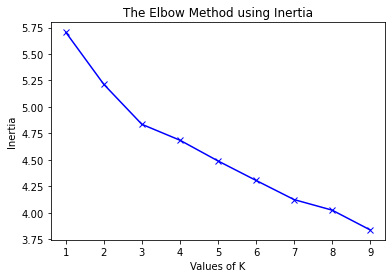

In [26]:
# plot the inertia against the value of K
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

Here it seems 3 is the appropriate choice according to elbow method.

In [27]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 3

mtr_grouped_clustering = mtr_grouped.drop('Station', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mtr_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1], dtype=int32)

Now add the clusters labels back to the data frame.

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

mtr_merged = mtr_stat

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
mtr_merged = mtr_merged.join(neighborhoods_venues_sorted.set_index('Station'), on='Station')

mtr_merged.head() 

,Station,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Admiralty,22.279643,114.164590,0,Hotel,Café,Steakhouse,Seafood Restaurant,Park,French Restaurant,Yoga Studio,Italian Restaurant,Vietnamese Restaurant,Furniture / Home Store
1,Airport,22.316087,113.936478,0,Airport Lounge,Coffee Shop,Bakery,Japanese Restaurant,Gift Shop,Clothing Store,Chinese Restaurant,Gym / Fitness Center,Furniture / Home Store,Fujian Restaurant
2,AsiaWorld-Expo,22.321251,113.942971,0,Boat or Ferry,Coffee Shop,Pool,Restaurant,Chinese Restaurant,Cocktail Bar,Bistro,Gym,Middle Eastern Restaurant,Metro Station
3,Austin,22.305491,114.166135,0,Chinese Restaurant,Dessert Shop,Café,Noodle House,Coffee Shop,Seafood Restaurant,Indian Restaurant,Supermarket,Shaanxi Restaurant,Fast Food Restaurant
4,Causeway Bay,22.280621,114.185087,0,Japanese Restaurant,Clothing Store,Bakery,Hotel,Dessert Shop,Sushi Restaurant,Noodle House,Department Store,Chinese Restaurant,Szechuan Restaurant


Let's plot the stations with cluster labels with color and add a heat map to the Hong Kong map for evaluation.

In [30]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from folium import plugins
from folium.plugins import HeatMap

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

latlon = [[lat, lon] for lat, lon in zip(mtr_merged['Latitude'], mtr_merged['Longitude'])]
HeatMap(latlon).add_to(map_clusters)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mtr_merged['Latitude'], mtr_merged['Longitude'], mtr_merged['Station'], mtr_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now with the heat map we can also see how the MTR stations network distributed in the city, and the area without coverage will have lesser coverage of public transport. Thus there will be less consumer flow too.

Let's look into each cluster and see the venue categories we can find. Firstly the first cluster (0) :

In [31]:
mtr_merged.loc[mtr_merged['Cluster Labels'] == 0, mtr_merged.columns[[0] + list(range(4, mtr_merged.shape[1]))]]

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Admiralty,Hotel,Café,Steakhouse,Seafood Restaurant,Park,French Restaurant,Yoga Studio,Italian Restaurant,Vietnamese Restaurant,Furniture / Home Store
1,Airport,Airport Lounge,Coffee Shop,Bakery,Japanese Restaurant,Gift Shop,Clothing Store,Chinese Restaurant,Gym / Fitness Center,Furniture / Home Store,Fujian Restaurant
2,AsiaWorld-Expo,Boat or Ferry,Coffee Shop,Pool,Restaurant,Chinese Restaurant,Cocktail Bar,Bistro,Gym,Middle Eastern Restaurant,Metro Station
3,Austin,Chinese Restaurant,Dessert Shop,Café,Noodle House,Coffee Shop,Seafood Restaurant,Indian Restaurant,Supermarket,Shaanxi Restaurant,Fast Food Restaurant
4,Causeway Bay,Japanese Restaurant,Clothing Store,Bakery,Hotel,Dessert Shop,Sushi Restaurant,Noodle House,Department Store,Chinese Restaurant,Szechuan Restaurant
5,Central,French Restaurant,Coffee Shop,Hotel,Japanese Restaurant,Bar,Lounge,Café,Yoga Studio,Chinese Restaurant,Gym / Fitness Center
11,Diamond Hill,Cantonese Restaurant,Shopping Mall,Garden,Chinese Restaurant,Vegetarian / Vegan Restaurant,Chocolate Shop,Tea Room,Singaporean Restaurant,Hakka Restaurant,Park
13,East Tsim Sha Tsui,Hotel,Japanese Restaurant,Hotel Bar,Cosmetics Shop,Hostel,Steakhouse,Chinese Restaurant,Coffee Shop,Boutique,South Indian Restaurant
16,Fortress Hill,Hotel,Coffee Shop,Cantonese Restaurant,Dessert Shop,Hong Kong Restaurant,Indian Restaurant,Bakery,Hotel Bar,Vietnamese Restaurant,Sushi Restaurant
21,HKU,Noodle House,Chinese Restaurant,Hong Kong Restaurant,Malay Restaurant,Spanish Restaurant,Burger Joint,Supermarket,Café,Cantonese Restaurant,Grocery Store


The second cluster (1) :

In [32]:
mtr_merged.loc[mtr_merged['Cluster Labels'] == 1, mtr_merged.columns[[0] + list(range(4, mtr_merged.shape[1]))]]

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Chai Wan,Chinese Restaurant,Cantonese Restaurant,Cha Chaan Teng,Fast Food Restaurant,Bus Stop,Coffee Shop,Hong Kong Restaurant,Theater,Shanghai Restaurant,Bakery
7,Che Kung Temple,Bus Station,History Museum,Chinese Restaurant,Fast Food Restaurant,Park,Café,Temple,French Restaurant,Fountain,Fried Chicken Joint
8,Cheung Sha Wan,Cha Chaan Teng,Dessert Shop,Fast Food Restaurant,Hong Kong Restaurant,Chinese Restaurant,Athletics & Sports,Ramen Restaurant,Seafood Restaurant,Cantonese Restaurant,Thai Restaurant
9,Choi Hung,Bus Stop,Bus Station,Cha Chaan Teng,Fast Food Restaurant,Park,Concert Hall,Convenience Store,Athletics & Sports,Snack Place,French Restaurant
10,City One,Fast Food Restaurant,Pharmacy,Coffee Shop,Convenience Store,Hong Kong Restaurant,Chinese Restaurant,Bakery,Café,Taiwanese Restaurant,Asian Restaurant
14,Fanling,Fast Food Restaurant,Platform,Dessert Shop,Housing Development,Bus Station,Mountain,Cantonese Restaurant,Bakery,Coffee Shop,Playground
15,Fo Tan,Chinese Restaurant,Fast Food Restaurant,Bakery,Cantonese Restaurant,Grocery Store,Food Court,Fountain,Food,Food & Drink Shop,French Restaurant
17,Hang Hau,Fast Food Restaurant,Café,Cantonese Restaurant,Noodle House,Chinese Restaurant,Athletics & Sports,Coffee Shop,Shopping Mall,Cha Chaan Teng,Park
18,Heng Fa Chuen,Cantonese Restaurant,Sporting Goods Shop,Fast Food Restaurant,Supermarket,Chinese Restaurant,Shopping Mall,Bakery,Shoe Store,Farmers Market,Park
19,Heng On,Bus Station,Fast Food Restaurant,Market,Chinese Restaurant,Track Stadium,Cha Chaan Teng,Supermarket,Athletics & Sports,Hong Kong Restaurant,Bus Stop


The third cluster (2) :

In [33]:
mtr_merged.loc[mtr_merged['Cluster Labels'] == 2, mtr_merged.columns[[0] + list(range(4, mtr_merged.shape[1]))]]

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Disneyland Resort,Theme Park Ride / Attraction,Parade,Fountain,Bakery,Souvenir Shop,Flea Market,Food,Food & Drink Shop,Food Court,Zoo Exhibit


The third cluster contains only Disneyland Resort, which is normal for being special.

Let's ploy the number of most common venues in each cluster on bar charts for better comparison.

In [34]:
# a funciton to return a Data Frame of number of common venues in a cluster.

def get_venue_cat(label, num) :
    hist = pd.DataFrame(mtr_merged.loc[mtr_merged['Cluster Labels'] == label])
    hist.drop(columns=['Station', 'Latitude', 'Longitude', 'Cluster Labels'], inplace=True)    
    top = pd.DataFrame(hist.stack().value_counts().head(num))
    top.rename(columns={0: 'Number of Venues in Cluster {}'.format(label)}, inplace=True)
    return(top)

In [35]:
cat0 = get_venue_cat(0, 10)
cat0

,Number of Venues in Cluster 0
Chinese Restaurant,36
Coffee Shop,36
Café,29
Hotel,24
Japanese Restaurant,23
Noodle House,17
Cantonese Restaurant,16
Sushi Restaurant,14
Fast Food Restaurant,14
Dessert Shop,13


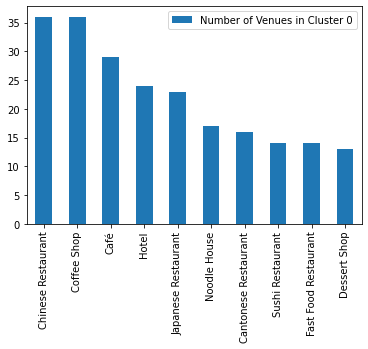

In [36]:
bg0 = cat0.plot.bar()
bg0.plot(figsize=(10,10));

So we can see the top ten venues in Cluster 0 is Chinese Restuarant, Coffee Shop, Cafe, Hotel and Japanese Restaurant, Noodle House, Cantonese Restaurant, Fast Food Restaurant, Sushi Restaurant and Dessert Shop.

Let's plot the number of different venues in cluster 1.

In [37]:
cat1 = get_venue_cat(1, 10)
cat1

,Number of Venues in Cluster 1
Fast Food Restaurant,39
Chinese Restaurant,27
Coffee Shop,20
Cha Chaan Teng,18
Hong Kong Restaurant,15
Shopping Mall,15
Park,12
Cantonese Restaurant,11
Bus Station,11
Café,10


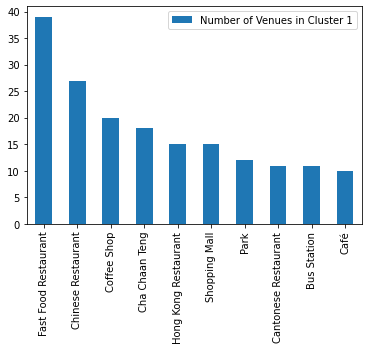

In [38]:
bg1 = cat1.plot.bar()
bg1.plot(figsize=(10,10));

So we can see the top ten venues in Cluster 1 is Fast Food Restaurant, Chinese Restuarant, Coffee Shop, Cha Chaan Teng, Shopping Mall, Hong Kong Restaurant, Park, Bus Station, Cantonese Restaurant and Cafe. 

In [39]:
cat2 = get_venue_cat(2, 10)
cat2

,Number of Venues in Cluster 2
Souvenir Shop,1
Parade,1
Theme Park Ride / Attraction,1
Food,1
Food & Drink Shop,1
Food Court,1
Zoo Exhibit,1
Flea Market,1
Bakery,1
Fountain,1


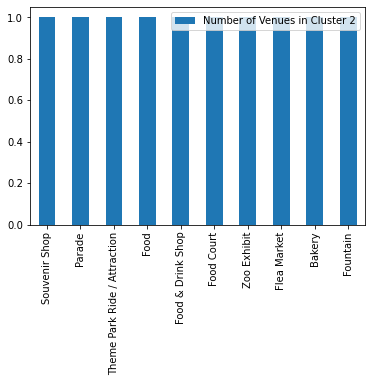

In [40]:
bg2 = cat2.plot.bar()
bg2.plot(figsize=(10,10));

We can see the venues of Disneyland Resort in cluster 2 :-) 

### Results and Discussion

In cluster 0, the stations in most busy commercial areas and around tourist attractions are included such as Admiralty, Central, Causeway Bay, Kwun Tong, Mong Kok, Quarrry Bay and Tsim Sha Tsui. However some densely populated residential areas are also included such as North Point and Sai Wan Ho, etc. In cluster 1, most stations are in residential area but because of the densely popluated environment in the city, there are also increasing numbers of commercial buildings in Kowloon Bay and Kwai Fong, etc. Cluster 2 only has station in Disneyland Resort, and opening business in Disneyland Resort is out of scope in this project.

In comparison of top 10 most common venue categories, the venue categories only exist in cluster 0 are Hotel, Japanese Restaurant, Noodle House, Sushi Restaurant and Dessert Shop. 
- more commercial premises and tourist attractions lead to more hotels around these stations.
- Japanese restaurants (including Sushi restaurant) are usually pricey in the local market, so we see more of them in the neighbourhoods becasue we have more dense commercial areas and tourist attractions around.
- Noodle shop here includes different style of noodles here but they are usually for a working day quick meal. 
- Dessert shops mainly serve dessert, especially Chinese style desert soup or pudding, and usually sell with a higher unit price with regards to normal meal.

The venue categories only exist in cluster 1 are Cha Chaan Teng, Shopping Mall, Park and Bus Station.
- Cha Chaan Teng is the speical type restaurant originated in Hong Kong that provides both local style cuisine and a mixture of Eastern and Western cuisines. Therefore more staitons in the neighbourhoods of dense residential areas lead to more number of them. They serve food fulfilling most of the local residents' needs. For those interested to read more, please refer to : https://en.wikipedia.org/wiki/Cha_chaan_teng
- more stations in residential areas also lead to more local Shopping Mall, Park and Bus Station. These are typically what local residents need for their daily life.

Anaysis from the data shows that opening a Japanese Restaurant, Dessert Shop or Cha Chaan Teng may suit in one cluster of neighbourhoods only. In the other cluster the lower number of such category already implicate a low demand of the service or product.

In contrast both clusters have significant numbers of Coffee Shop, Chinese Restaurant, Café, Cantonese Restaurant and Fast Food Restaurant in the neighbourhoods. Therefore in all neighbouhoods these categories of business have a large demand and can exist together at a same time.

There is one category in cluster 1 that appears to be overlapped with other venue categories. The "Hong Kong Restaurant" term seems ambiguous and let's inspect the first 50 of them :

In [41]:
mtr_venues[mtr_venues['Venue Category'].str.contains('Hong Kong Restaurant')].head(50)

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
204,Causeway Bay,22.280621,114.185087,Wing's Catering (榮式燒雞扒),22.277385,114.186429,Hong Kong Restaurant
216,Causeway Bay,22.280621,114.185087,Kowloon Restaurant (九龍餐室),22.279086,114.180639,Hong Kong Restaurant
331,Chai Wan,22.264783,114.237238,Yeh Lam Kwok (椰林閣),22.263780,114.236988,Hong Kong Restaurant
344,Chai Wan,22.264783,114.237238,泉記金喜來海鮮飯店,22.265425,114.240492,Hong Kong Restaurant
356,Cheung Sha Wan,22.335578,114.156231,Sum's Cuisine & Restaurant (森記餐室飯館),22.336142,114.158479,Hong Kong Restaurant
369,Cheung Sha Wan,22.335578,114.156231,Redrice (Redrice 米飯主題餐廳),22.337675,114.158110,Hong Kong Restaurant
382,Cheung Sha Wan,22.335578,114.156231,Rice Love (飯意主題餐廳),22.334337,114.160764,Hong Kong Restaurant
401,City One,22.383017,114.203754,ItaMoMo Café (意八餐廳),22.381653,114.205117,Hong Kong Restaurant
415,City One,22.383017,114.203754,叻哥茶餐廳,22.386703,114.204142,Hong Kong Restaurant
538,East Tsim Sha Tsui,22.295301,114.174600,Mui Kee Cookfood Stall (妹記大排檔),22.299378,114.173436,Hong Kong Restaurant


From the list we can see they are actually Cha Chaan Teng or Cantonese Restaurant. In fact usually Cha Chaan Teng are positioned in the lower price range, branding themselves as a Hong Kong Restaurant may be more appropriate to their pricing strategies.

Coffee Shop and Café actually means the same type of business, and it indicates the demand for a cup of tea/coffe and quick meal is high too. A coffee shop requires mush less space than a restaurant, so it costs less to operate one in comparison. And this is why in cluster 0 we have more Coffee Shop or Café, due to the expensive cost of rent in dense commercial areas.

### Conclusion

The purpose of this project is to explore the neighbours around MTR stations in the city and evaluate the business prospects for opening a local business nearby. We extracted location data for each MTR stations, we used Foursquare API to prepare data of surrounding neighbourhoods, and then we used K-means clustering to build a model for further segmentation. After analysis of the collected data Coffee Shop, Chinese Restaurant, Café, Cantonese Restaurant and Fast Food Restaurant are the type of business in demand, nad have better opportunities to sustain in the neighbourhood. 

According to 2016 Population By-census (https://www.bycensus2016.gov.hk/en/bc-mt.html), 92% of the population of Hong Kong are ethnic Chinese. Although it did not categorize Han Chinese subgroups, it also explains the reason why this analysis results in Chinese Restaurant, especially Cantonese Restaurant, stands out among the venue categories. Indeed the Fast Food restaurants in the city serve a lot of Chinese dishes and Cantonese dishes as well. 

Opening a local business will still need to consider a lot of factors such as invester's interest, wages level, competitors nearby, location from the MTR station, actual customer flow, etc. The analysis above should provide additional tools in the decision making during the process. 